# **<노드 실습>**

## **노드 8 - 미니프로젝트: ARIMA, ARCH**

## 프로젝트 목표
- 1) 직접 ARIMA를 통해 시계열 예측을 수행해보기
- 2) 직접 ARCH를 통해 S&P500의 변동성을 모델링해보기


### 라이브러리 설치하기

In [21]:
!pip install arch==6.3.0

In [22]:
!pip install pmdarima

In [23]:
# 기존 설치 패키지 제거
!pip uninstall -y numpy pmdarima statsmodels

# 최신 버전 설치
!pip install numpy==1.24.4 statsmodels==0.13.5 pmdarima==2.0.4

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: statsmodels 0.13.5
Uninstalling statsmodels-0.13.5:
  Successfully uninstalled statsmodels-0.13.5
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached statsmodels-0.13.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached statsmodels-0.13.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl 

### 1) 데이터 확인하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf plot 및 pacf plot을 그리기 위한 라이브러리
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델
import pmdarima as pm # Auto ARIMA 모델

- 지난번에 AirPassengers 데이터는 비정상 시계열임을 알 수 있었다.
- 따라서, 비정상 시계열을 정상 시계열로 만드는데 'Month' 컬럼은 필요 없으므로 삭제한다.

In [2]:
url = '/content/AirPassengers.csv'

ap = pd.read_csv(url)
ap.drop('Month', axis = 1, inplace = True)

print(ap.head())

   #Passengers
0          112
1          118
2          132
3          129
4          121


- 지난번과 마찬가지로, matplotlib을 통해서 AirPassengers 데이터를 그려서 확인한다.

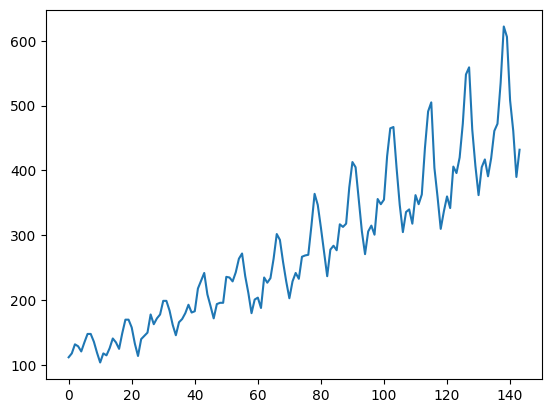

In [3]:
plt.plot(ap)
plt.show()

- 위 그래프가 상승하는 추세이고, 점점 분산이 커지므로 완벽한 비정상 데이터이다. -> 분산을 줄이고, 증가하는 추세를 제거하면 정상 시계열 데이터를 얻을 수 있을것이다!
- 먼저, 분산을 일정하게 만들고 시작해야 하므로 로그 변환을 통해 분산을 일정하게 만들어 준다.

### 2) 분산을 일정하게 만들기 -> 로그변환

In [5]:
ap_transformed = np.log(ap) # np.log를 통해 로그변환한다.

In [6]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


- 이 로그변환된 데이터를 가지고 ACF와 PACF의 그래프를 그려본다.

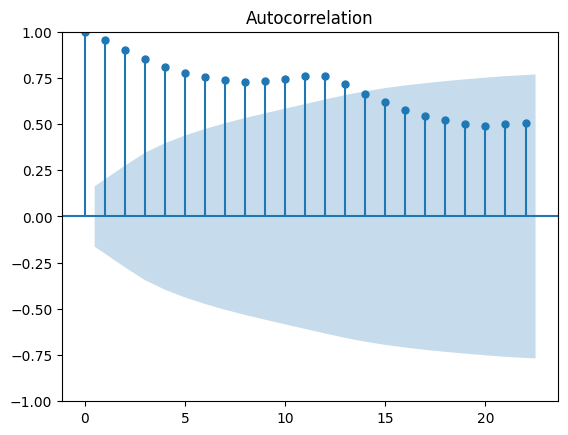

In [7]:
plot_acf(ap_transformed) # ACF plot은 점차 감소하는 모양새를 지니고 있다.
plt.plot();

- 위 그래프에서 파란색 면적이 아닌 부분에 해당하면 유의미하다는 의미이므로, 굉장히 많은 부분이 유의미하다고 볼 수 있다.

/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


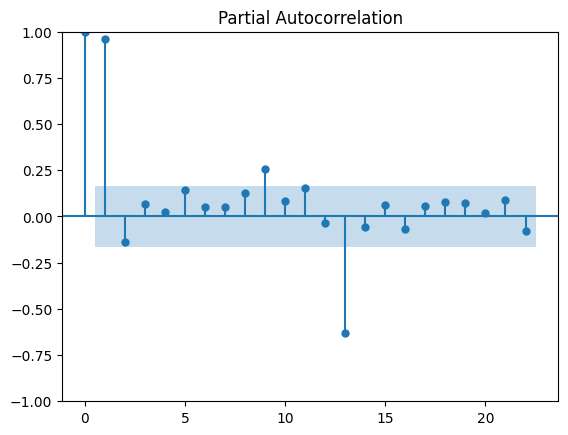

In [8]:
plot_pacf(ap_transformed) # PACF plot은 lag 2까지 유의미한 결과를 보인다.
plt.plot();

- PACF의 경우, 0(자기자신), 1, 12정도 쯤에서 유의미한 결과를 보인다.
- 아직 증가하는 추세가 남았으므로, ACF plot과 PACF plot이 이러한 모양을 띠고 있다고 추측할 수 있다.
- 이 데이터를 좀 더 제대로 적합시키기 위해서는, 차분을 통해 추세를 제거해주고 ACF plot과 PACF plot을 확인해야 한다.
- 일단, 로그변환한 데이터에 차분을 해주고 NaN값을 제거한다.

### 3) 차분을 통해 분석하기
- ACF plot, PACF plot과 차분을 활용하여 분석한다.

In [9]:
ap_diff = ap_transformed.diff()
ap_diff = ap_diff.dropna()

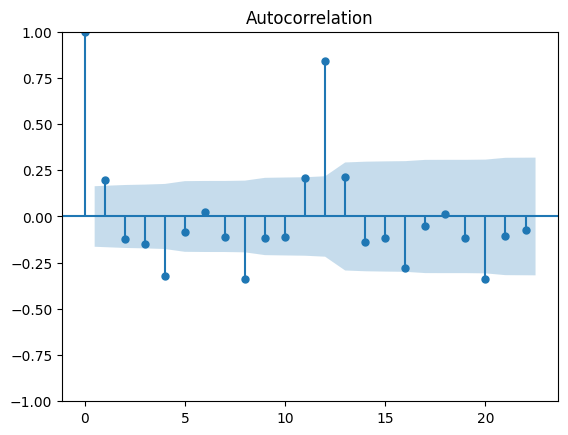

In [10]:
plot_acf(ap_diff)
plt.plot();

- 위 그래프에서 lag 1과 lag 12에서 유의미한 lag가 포착되었다.

/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


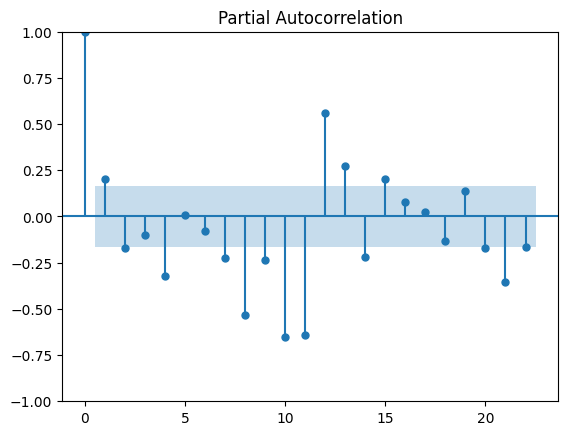

In [11]:
plot_pacf(ap_diff)
plt.plot();

- 위 그래프에서, lag 1, lag 8~12쯤에서 유의미한 lag가 포착되었다.
- 위의 2개의 그래프를 확인해 본 결과, 모두 lag=12쯤에서 유의미하다는 것을 알 수 있다. -> 이는 전에 보았던 '계절성 성분'이라고 추측할 수 있다.
- Auto-ARIMA를 적합할 때 계절성을 고려해야한다.


In [12]:
ap_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


- test 데이터 세트에도 해당 데이터를 활용해야 하므로, train: test = 8:2로 데이터를 분리하고, 앞에있는 80% 데이터 세트만 적합시킨다.

In [13]:
train_size = int(len(ap_transformed)*0.8)

ap_transformed_train = ap_transformed[:train_size]
ap_transformed_test = ap_transformed[train_size:]

### 4) Auto ARIMA 적용 및 결과 확인

- 이제, Auto-ARIMA로 모델을 적합시킨다.
- 아래 코드에서 max_D는 SARIMA에서 계절성 성분이 반영된 것을 나타낸다.
- Auto-ARIMA 구성 인자
  - **seasonal: False인 경우, non-seasonal 모델로 제한함**
  - suppress_warnings: ARIMA를 실행하면 생기는 에러 문구를 안나오게 함
  - trace: True일때 오류(error)가 발생하면 일부 내용을 출력함
  - **max_D: seasonal의 최댓값을 설정할 수 있음**

In [14]:
# AutoARIMA
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12) # seasonal = True, max_D(계절차분) = 12로 지정한다.
res = model.fit(ap_transformed_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-196.702, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-196.895, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-211.688, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-219.764, Time=0.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-222.508, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-223.487, Time=0.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-219.466, Time=0.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,5)(0,0,0)[0]             : AIC=-216.037, Time=0.54 sec

Best model:  ARIMA(1,1,5)(0,0,0)[0] intercept
Total fit time: 7.120 seconds


- 위의 결과, 최종적으로 가장 좋은 모델은 ARIMA(1,1,5)임을 알 수 있다.
- 이제 이 모델의 예측성능이 얼마나 좋은지 알아보기 위해 그래프를 그려본다.
  - 신뢰구간(conf_int)까지 시각화를 해서, 모델이 얼마나 정확한지 본다.


In [15]:
preds, conf_int = res.predict(n_periods=ap_transformed_test.shape[0], return_conf_int=True) # 신뢰구간(confidence interval)까지 도출해본다.


# 아래의 코드 결과값을 서로 비교 분석해본다.
print(preds.shape)
print(type(preds))
print('--'*40)
print(preds.shape[0])
print(type(preds.shape[0]))
# print('--'*40)
# print(preds)
# print('--'*40)
# print(conf_int)

(29,)
<class 'pandas.core.series.Series'>
--------------------------------------------------------------------------------
29
<class 'int'>


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


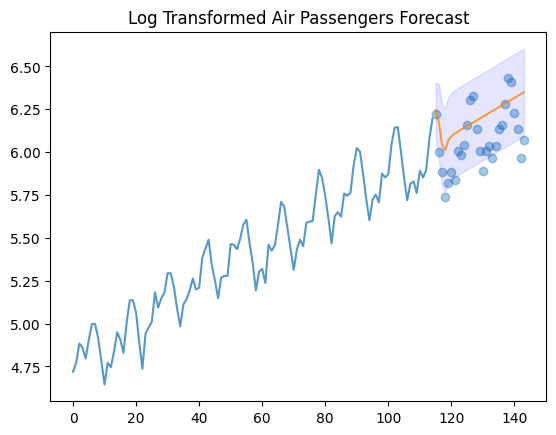

In [16]:
# 예측 성능을 시각화합니다.
# 0. train과 test data를 축(axis)으로 만들었습니다.
# 1. x축은 test으로 만들어 놓은 train data를 사용하고, y축에 train data를 사용하여 train data를 시각화합니다.
# 2. 1번 그래프에서 정답(AutoARIMA를 통해 만든 예측 값)에 해당하는 일자형 그래프가 생성됩니다.
# 3. 원래 가지고 있던 데이터셋의 y값(지도 학습의 정답)을 산점도(scatter plot)로 생성합니다.
# 4. 2, 3번의 분포에 해당하는 구간을 채워 그래프로 나타냈습니다.


x_axis = np.arange(ap_transformed_train.shape[0] + preds.shape[0]) # 0: 115 + 29, plot을 그리기 위해 x축을 생성합니다.
plt.plot(x_axis[:ap_transformed_train.shape[0]],ap_transformed_train, alpha=0.75) # 1
plt.plot(x_axis[ap_transformed_train.shape[0]:], preds, alpha=0.75) # 2
plt.scatter(x_axis[ap_transformed_train.shape[0]:],ap_transformed_test,
            alpha=0.4, marker='o')  # 3: 기존 test data는 scatter
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b') # 4
plt.title("Log Transformed Air Passengers Forecast") # plot의 제목

plt.show() # 4개의 plot을 시각화한다.

- 위 그래프에서 주황색 선 그래프는 ARIMA(1,1,5) 모델이 점추정한 선을 나타낸다.
- 실제값들이 95% 신뢰구간 안에 대부분 다 위치해 있는것을 알 수 있다.
- 따라서, ARIMA(1,1,5) 모델은 로그변환된 AirPassengers 데이터를 비교적 잘 예측한다고 할 수 있다.

### 5) ARCH 모델 실습해보기

- 우선, 데이터를 시각화해서 수익률 그래프를 그려본다.

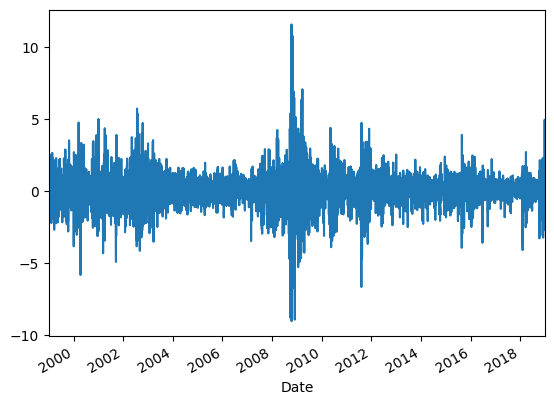

In [17]:
# 데이터 및 라이브러리 불러오기
import datetime as dt # 날짜와 시간을 조작할 수 있는 Python 라이브러리
import arch.data.sp500 # S&P 500 데이터셋을 arch에서 불러온다.


# 필요한 데이터로 가공하고 시각화를 통해 확인하기
st = dt.datetime(2002, 1, 1) # start date
en = dt.datetime(2022, 1, 1) # end date
data = arch.data.sp500.load() # s&p 500 데이터 불러오기
market = data["Adj Close"] # 종가만 활용
returns = 100 * market.pct_change().dropna() # return값으로 변환
ax = returns.plot() # 수익률을 그래프로 만들기
xlim = ax.set_xlim(returns.index.min(), returns.index.max()) # xlim은 x축 값의 보기를 제한

plt.show()

- 위 그래프를 보면, 조건부 이분산성(Conditional Heteroskedasticity)이 나타나는 것을 알 수 있다.
- 그러면 이제, ARCH를 적합시켜본다.

In [18]:
# ARCH 모델 적용
from arch import arch_model

am = arch_model(returns) # return을 arch모델에 적합
res = am.fit(update_freq=5)

# 지표를 통한 결과 확인
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Mon, May 26 2025   Df Residuals:                     5029
Time:         

- 위 summary표에는 다양한 지표값들이 있으나, 수업때 배웠던 p-value, AIC, BIC 위주로 결과를 해석해본다.
- 위의 결과에서, 우리는 Volatility Model을 중점적으로 본다.
  - alpha[1], beta[1]은 GARCH(1,1)을 의미하며, p < 0.05 이므로, 95% 신뢰수준에서 이것이 유의미하다는 결과를 도출할 수 있다!
- 즉, S&P500 20년치의 데이터의 volatility는 GARCH(1,1)이라고 하는 확률 가정을 따른다고 결론을 내릴 수 있다!

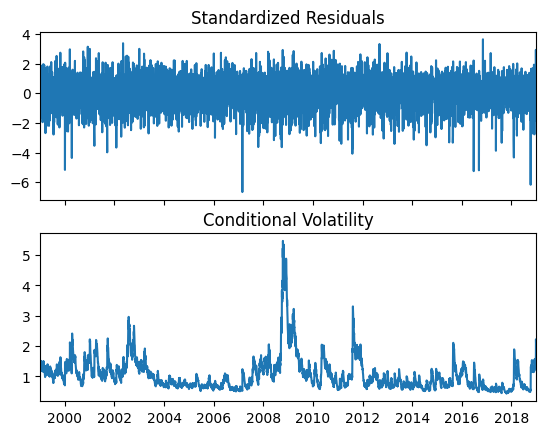

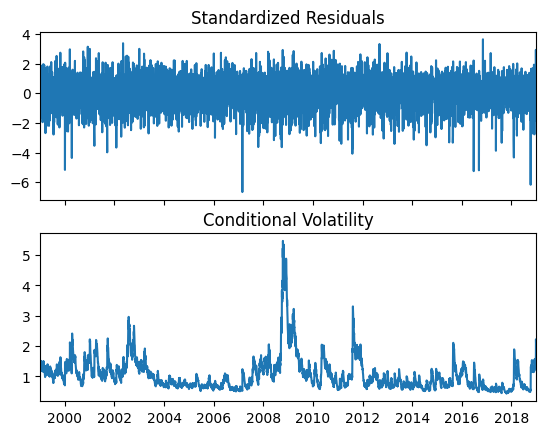

In [19]:
# 시각화를 통한 결과값 확인
res.plot()